# Домашняя работа

**Ответить на вопросы**
- Хотим повысить выручку минимум на 6% за 4 месяца. Будем повышать за счет роста Retention минимум на  3% и среднего чека минимум на 3%
- Топ-5 товаров, а не топ-10 (В e-mail 10 выглядят не красиво, в push и на чек больше 5 не влезает)
- Рассылаем в e-mail (5% клиентов) и push-уведомлении (20% клиентов), печатаем на чеке (все оффлайн клиенты)
- **3 товара с акцией** (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)
- **1 новый товар** (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?) 
- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

$$L_{\text{WRMF}}=\sum_{u,i}c_{u,i}(p_{ui}-x_u^T\cdot y_i)^2+\lambda_x \sum_u ||x_u||^2+\lambda \sum_u ||y_i||^2$$

**Как учеть, что нужно включать в рекомендации 3 товара?** 

1. Проще всего учесть акционные товары увеличив вес ошибки $c_{u,i}$ при ALS разложении. Например увеличив вес ошибки пропорционально размеру скидки. 
2. Второй вариант это разбивать исходную матрицу на две, одна состоит из неакционных товарок, вторая полностью состоит из этих товаров. 
3. Можно еще предложить увеличить score релевантности непосредственно в user-item матрице (аналогичным способом - пропорционально скидке на товар). 
1 и 2 способ неудобны с точки зрения того, что если какой-то товар изменяет свой статус (акционный или нет), то нужно занова пересчитывать item-сущности матрицы (хоть это и достаточно быстро). Также только 2 способ гарантирует нам, что в список рекомендаций попадут строго 3 товара, другие же повышают вероятность попадания данного товара в список рекомендаций.
В любом случае в предложенных решениях, чем больше скидка, тем больше вероятность того, что товар попадет в список рекомендаций.

**Как предлогать пользователю товары которые он никогда не покупал?**

Из получившейся user-item матрицы можно удаляет товары которые пользователь уже покупал. Далее фильтруем их по score и получаем результаты. Однако, что делать если score очень маленький? Тогда, возможно, есть смысл использовать какой-нибуль другую модель или baseline, но из прогнозов удалять товары, которые пользователь покупал. 

**Как учесть товары которые дороже чем обычно покупает юзер. Насколько дороже нужно выбрать?**

Для начала делаем ALS разложоение. Далее находим похожие товары, на те товары, которые чаще всего (или раз в месяц) покупает user. Затем выбрать тот товар, который подороже. Цена преложеного товара должна быть не меньше цены расчитаной по формуле:

$$\frac{\text{average_check} \cdot 0.03}{\text{item_count}\cdot \text{old_price}}+1,$$ 
где $\text{average_check}$ - средний чек, $\text{item_count}$ - количество товара купленого за месяц, $\text{old_price}$ - цена за старый товар. Эта формула позволяет обеспечить прирост среднего чека на 3 и более процента 

## Дописать функцию prefilter_items

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k

In [3]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [23]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [72]:
filter_ = data_train['quantity'] > 1

data_train['price_for_item'] = data_train['sales_value']
data_train.loc[filter_, 'price_for_item'] = data_train.loc[filter_, 'price_for_item'] / data_train.loc[filter_, 'quantity']

max_sum_4_filter = 100
data_train.loc[data_train['price_for_item'] > max_sum_4_filter, 'price_for_item'].shape

<ipython-input-72-9f5d0c36fa8b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price_for_item'] = data_train['sales_value']
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


(53,)

In [ ]:
def prefilter_items(data, 
                   list_of_uninteresting_items = ['PHARMACY SUPPLY'], 
                   min_price_4_filter = .9, 
                   max_price_4_filter = 100):
    
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist() # товары о которые покупали более 50% users
    data = data[~data['item_id'].isin(top_popular)] # выбираем не популярные товары
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    month_without_sales = 12
    weeks_a_month = 4

    time_filter = data['week_no'] < data['week_no'].max() - month_without_sales * weeks_a_month
    quntity_filter = data['quantity'] == 0
    data = data[~(time_filter & quntity_filter)]
    
    # Уберем не интересные для рекоммендаций категории (department)
    unintersting_items = item_features.loc[item_features['department'].isin(list_of_uninteresting_items), 'item_id'].values
    data = data[~data['item_id'].isin(unintersting_items)]
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
    # Цены указаны в долларах. Будем убирать товары дешевле 0,9 долларов
    filter_ = data['quantity'] > 1
    
    data['price_for_item'] = data['sales_value']
    data.loc[filter_, 'price_for_item'] = data.loc[filter_, 'price_for_item'] / data.loc[filter_, 'quantity']
    data = data[data['price_for_item'] > min_price_4_filter]

    
    # Уберем слишком дорогие товары
    data.loc[data['price_for_item'] > max_sum_4_filter].drop('price_for_item', axis=1)
    
    return data
    
    
def postfilter_items(user_id, recommednations):
    # ...
    pass

## Поэкспериментировать с ALS (grid-search)

In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [6]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [7]:
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [73]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 2.92 s


In [104]:
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

0.15749265426052683

- regularization, iterations
- factors
- Вес (элемент в матрице user-item)

In [83]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [75]:
params_grid = {
    'factors': [20, 40, 50, 60, 80, 100], 
    'regularization': [0.1, 0.01, 0.001, 0.0001],
    'iterations': [5, 10, 15, 20, 25, 30, 40],
    'num_threads': [4]
}


In [108]:
from itertools import product
from tqdm import tqdm

import swifter
# swifter.config.

score = []
result_ = result.copy()

keys, values = zip(*params_grid.items())
for val in tqdm(product(*values), total=len(list(product(*values)))):
    params = dict(zip(keys, val))
    model = AlternatingLeastSquares(**params)
    model.fit(csr_matrix(user_item_matrix).T.tocsr(), show_progress=False)
    
    column_name = f'{params}'
#     result_[column_name] = result_['user_id'].swifter.apply(lambda x: get_recommendations(x, model=model, N=5))
    result_[column_name] = result_['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    
#     score.append(result_.swifter.apply(lambda row: precision_at_k(row[column_name], row['actual']), axis=1).mean())
    score.append(result_.apply(lambda row: precision_at_k(row[column_name], row['actual']), axis=1).mean())
    

100%|████████████████████████████████████████████████████████████████████████████████| 168/168 [56:03<00:00, 20.02s/it]


In [124]:
params_list = list(product(*values))
best_params = sorted(list(zip(score, params_list)), key=lambda x: [x[0]], reverse=True)[0]

'{}! {}'.format(*best_params)


'0.17502448579823443! (60, 0.1, 5, 4)'

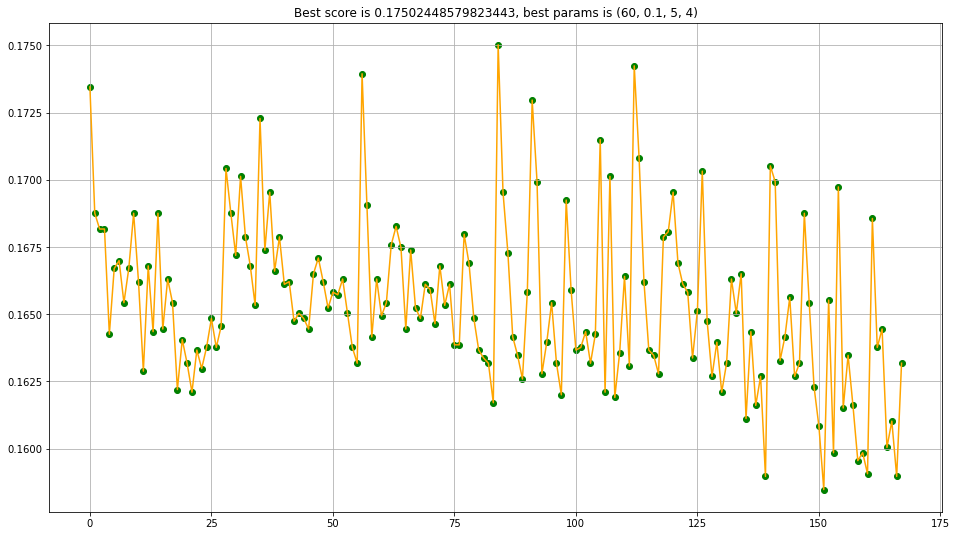

In [125]:
params_list = list(product(*values))
best_params = sorted(list(zip(score, params_list)), key=lambda x: [x[0]], reverse=True)[0]

plt.figure(figsize=(16, 9))
plt.plot(range(len(params_list)), score, c='orange')
plt.scatter(range(len(params_list)),score, c='green')
plt.title('Best score is {}, best params is {}'.format(*best_params))
plt.grid(True)
plt.show()